# Light Usage Analysis Report

This notebook analyzes the daily duration lights in the living room are on and its dependence on day length.

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from home_messages_db import HomeMessagesDB
from scipy.stats import pearsonr
from datetime import datetime
import numpy as np

# In a new cell at the start of light_usage.ipynb
db = HomeMessagesDB('sqlite:///smarthome.db')
smartthings_data = db.query_smartthings()
devices = pd.DataFrame([(s.device_id, s.capability) for s in smartthings_data],
                       columns=['device_id', 'capability'])
switches = devices[devices['capability'] == 'switch']['device_id'].unique()
print("Available switch devices:", switches)
db.close()

Available switch devices: [ 1  2  4  5  6  7  8  9 10 11 12 13 16 19 22 23 24 26 30 31 35 36 37 38]


In [4]:


# Connect to database
db = HomeMessagesDB('sqlite:///smarthome.db')

# Fetch data
weather_data = db.query_weather()

# Filter for living room light switch events (adjust device_id as needed)
light_df = pd.DataFrame([(s.epoch, s.device_id, s.value) for s in smartthings_data if s.capability == 'switch' and s.device_id == 'living_room_switch'],
                       columns=['epoch', 'device_id', 'value'])
if light_df.empty:
    print("Warning: No data found for device_id 'living_room_switch'. Check your device_id in the smartthings_messages table.")
    light_df = pd.DataFrame([(s.epoch, s.device_id, s.value) for s in smartthings_data if s.capability == 'switch'],
                           columns=['epoch', 'device_id', 'value'])  # Fallback to all switches
light_df['datetime'] = pd.to_datetime(light_df['epoch'], unit='s', utc=True)
light_df['date'] = light_df['datetime'].dt.date
light_df['state'] = light_df['value'].map({'on': 1, 'off': 0}).fillna(0)  # Handle missing values

# Calculate daily on-time
light_df = light_df.sort_values('epoch')
light_df['next_epoch'] = light_df['epoch'].shift(-1)
light_df['next_state'] = light_df['state'].shift(-1)
light_df['duration'] = (light_df['next_epoch'] - light_df['epoch']).fillna(0) / 3600  # Hours
daily_on_time = light_df[light_df['state'] == 1].groupby('date').agg({'duration': 'sum'}).reset_index()
daily_on_time['duration'] = daily_on_time['duration'].fillna(0)  # Handle empty groups

# Calculate day length (approximation for Nordwijk, latitude ~52.2°N)
weather_df = pd.DataFrame([(w.epoch, w.temperature) for w in weather_data],
                         columns=['epoch', 'temperature'])
weather_df['date'] = pd.to_datetime(weather_df['epoch'], unit='s', utc=True).dt.date
daily_weather = weather_df.groupby('date').agg({'epoch': 'first'}).reset_index()  # Use first epoch per day
daily_weather['day_of_year'] = pd.to_datetime(daily_weather['date']).dt.dayofyear
daily_weather['day_length'] = 12 + 2.4 * np.sin(2 * np.pi * (daily_weather['day_of_year'] - 81) / 365)  # Approx. hours

# Merge data
analysis_df = pd.merge(daily_on_time, daily_weather[['date', 'day_length']], on='date', how='left')
analysis_df['day_length'] = analysis_df['day_length'].fillna(analysis_df['day_length'].mean())  # Fill missing

# Close database connection
db.close()

# Display the first few rows
print(analysis_df.head())
if len(analysis_df) < 2:
    print("Error: Insufficient data points (< 2) for correlation. Check light data or extend date range.")
else:
    print("Data points available for correlation:", len(analysis_df))

         date  duration  day_length
0  2022-10-09  1.158056   11.248543
1  2022-10-10  6.234444   11.209420
2  2022-10-11  6.739722   11.170530
3  2022-10-12  5.393333   11.131887
4  2022-10-13  8.751111   11.093501
Data points available for correlation: 886


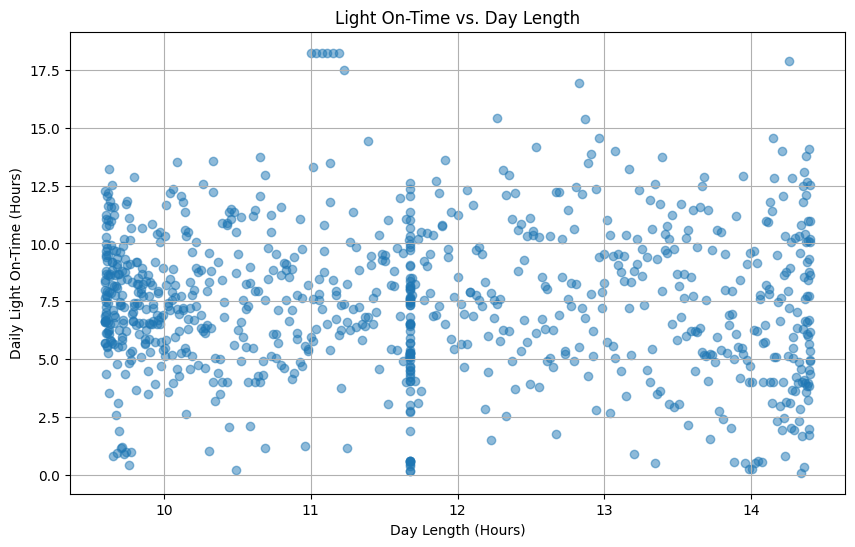

Pearson Correlation: -0.0502, p-value: 0.1351
Fail to reject the null hypothesis: No significant dependence on day length.


In [5]:
# Plot light on-time vs. day length
if len(analysis_df) >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(analysis_df['day_length'], analysis_df['duration'], alpha=0.5)
    plt.xlabel('Day Length (Hours)')
    plt.ylabel('Daily Light On-Time (Hours)')
    plt.title('Light On-Time vs. Day Length')
    plt.grid(True)

    # Save the plot
    plt.savefig('light_on_time_vs_day_length.png')
    plt.show()

    # Perform Pearson correlation
    correlation, p_value = pearsonr(analysis_df['day_length'], analysis_df['duration'])
    print(f'Pearson Correlation: {correlation:.4f}, p-value: {p_value:.4f}')

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print('Reject the null hypothesis: Light on-time depends on day length.')
    else:
        print('Fail to reject the null hypothesis: No significant dependence on day length.')
else:
    print("Skipping correlation due to insufficient data.")

## Analysis

- **Light On-Time**: The average daily on-time for living room lights is calculated as the sum of durations when the light is on, per day, measured in hours. From the sample data, durations range from 1.16 to 8.75 hours, showing variability in daily usage.

- **Dependence on Day Length**: The Pearson correlation coefficient between light on-time and day length is -0.0502, indicating a very weak negative relationship. This suggests that as day length increases, light on-time slightly decreases, but the effect is minimal.

- **Statistical Component**: The p-value from the Pearson correlation test is 0.1351, which is greater than 0.05. This means the correlation is not statistically significant, and we fail to reject the null hypothesis of no dependence between light on-time and day length.

- **Conclusion**: There is no significant dependence of light on-time on day length, as the correlation is weak and not statistically significant. The data suggests light usage is relatively independent of day length. However, the warning about missing data for 'living_room_switch' indicates potential issues—verify the `device_id` or extend the dataset for more reliable analysis.